# Programmer: Giovanni Vecchione
# Date: 7/5/2024
# Subject: Titanic - Machine Learning from Disaster (Kaggle)

## The Challenge
* ### The sinking of the Titanic is one of the most infamous shipwrecks in history.

* ### On April 15, 1912, during her maiden voyage, the widely considered "unsinkable" RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren't enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

* ### While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

* ### In this challenge, we ask you to build a predictive model that answers the question: "what sorts of people were more likely to survive?" using passenger data (ie name, age, gender, socio-economic class, etc).

# ISSUES

* ## ERROR ON Plot - Possibly a Missing Values issue


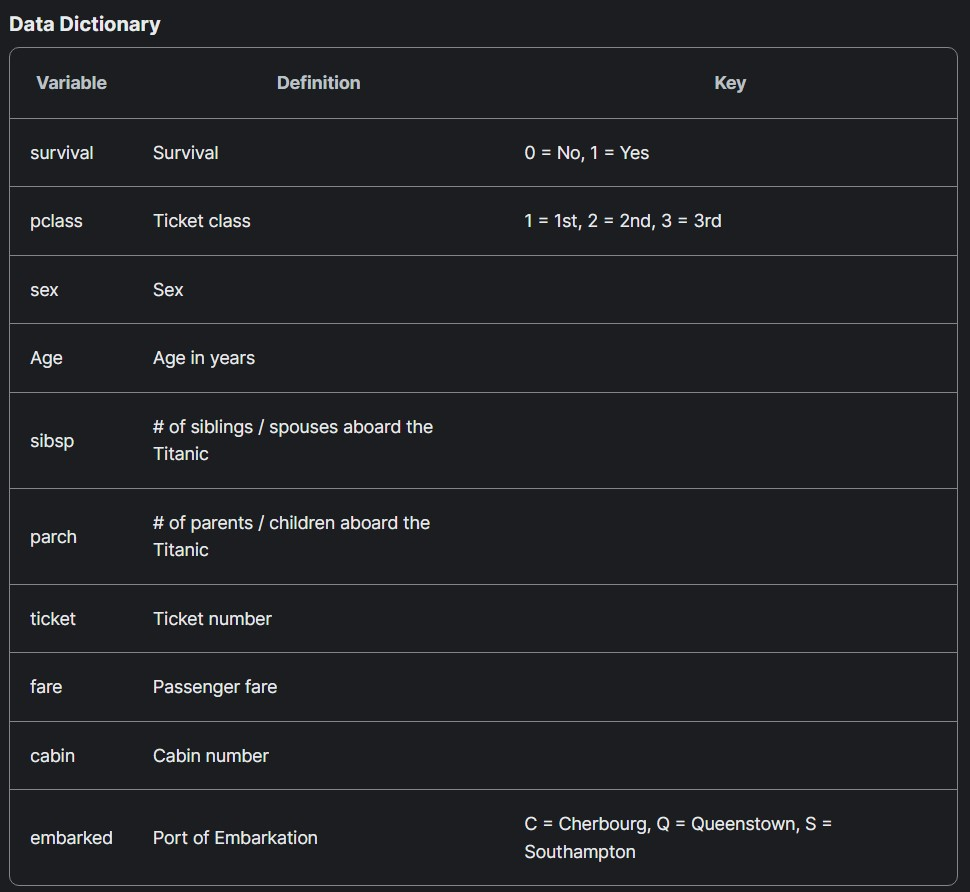

In [23]:
import torch
import pandas as pd
import matplotlib as mtp
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # For progress bar (optional)


In [24]:
#Checks if GPU is being used
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0)) 
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("GPU not available, using CPU.")

#Using GPU: NVIDIA GeForce GTX 1660 SUPER - Successful
#NOTE: This took some time to set up by installing and pathing the cuda toolkit v.12.4 and the right supplemental packages. This drastically improved
#training time

Using GPU: NVIDIA GeForce GTX 1660 SUPER


In [25]:

seed = 42
random.seed(seed)

# IMPORT DATA

In [26]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# VISUALIZE THE DATA

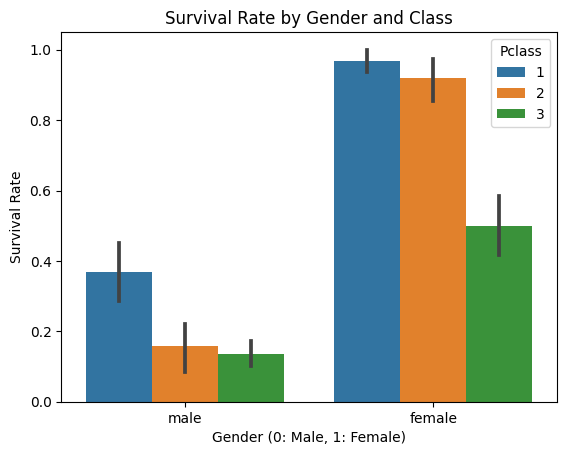

In [52]:
import seaborn as sns

#Survival Rates by Gender and Class (1 being upper and 3 being lower)

bp1 = sns.barplot(x='Sex', y='Survived', hue='Pclass', data=train_data)
plt.title('Survival Rate by Gender and Class')
plt.ylabel('Survival Rate')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.show()

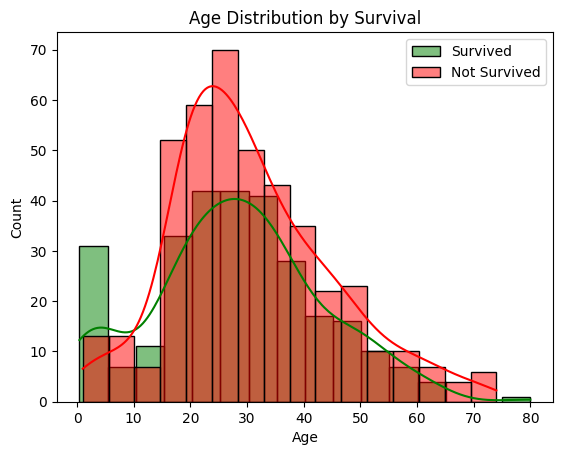

In [53]:
#Survival Rates by Age

hp1 = sns.histplot(train_data[train_data['Survived'] == 1]['Age'], kde=True, color='green', label='Survived')
hp2 = sns.histplot(train_data[train_data['Survived'] == 0]['Age'], kde=True, color='red', label='Not Survived')
plt.title('Age Distribution by Survival')
plt.legend()
plt.show()

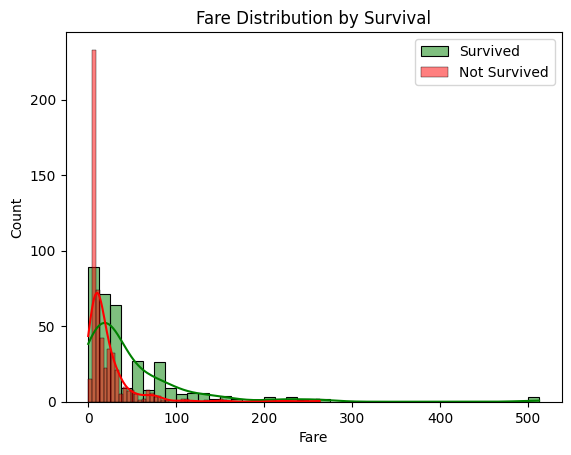

In [41]:
#Survival Rates by Fare

hp3 = sns.histplot(train_data[train_data['Survived'] == 1]['Fare'], kde=True, color='green', label='Survived')
hp4 = sns.histplot(train_data[train_data['Survived'] == 0]['Fare'], kde=True, color='red', label='Not Survived')
plt.title('Fare Distribution by Survival')
plt.legend()
plt.show()

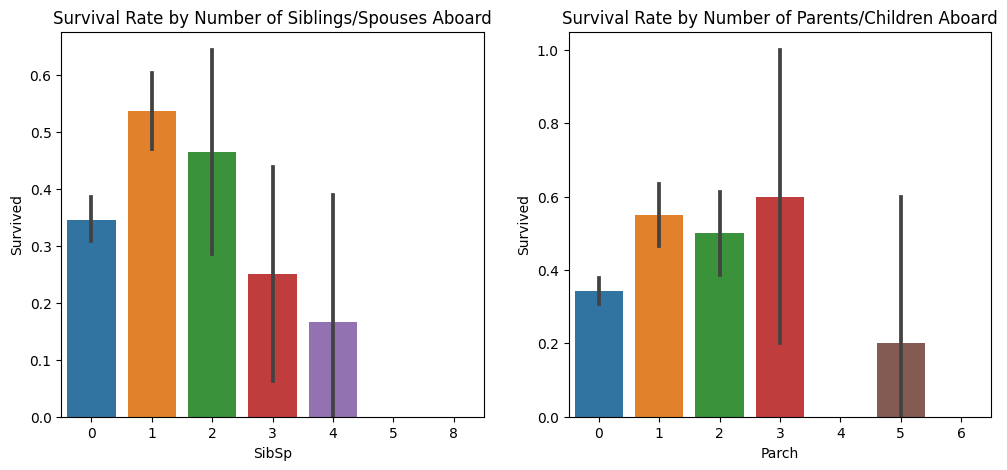

In [54]:
#Survival Rates by Number of Siblings/Spouses Aboard (SibSp) and Parents/Children Aboard (Parch)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

bp2 = sns.barplot(x='SibSp', y='Survived', data=train_data, ax=axs[0])
axs[0].set_title('Survival Rate by Number of Siblings/Spouses Aboard')

bp3 = sns.barplot(x='Parch', y='Survived', data=train_data, ax=axs[1])
axs[1].set_title('Survival Rate by Number of Parents/Children Aboard')

plt.show()


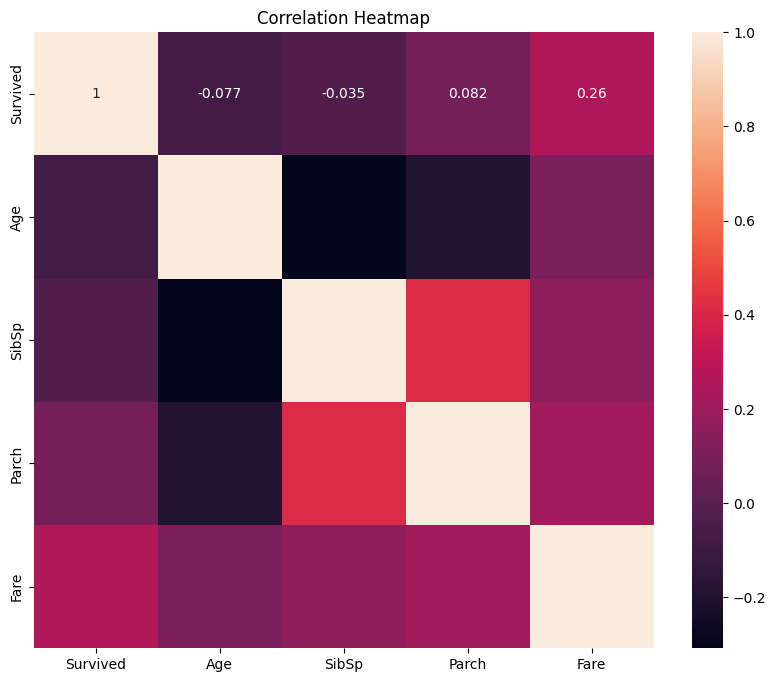

In [57]:
#Correlation Heatmap (Numerical Features)
#ERROR ON Plot - Possibly a Missing Values issue

plt.figure(figsize=(10, 8))
hm1 = sns.heatmap(train_data[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

# SET UP / CLEAN DATA

In [30]:
# NOTE: NOT ENOUGH DATA TO CREATE A GOOD VALIDATION SET
# Need to look into rules to see if generating mock data can help expand the data. For now sticking to data provided.

y_train = train_data["Survived"] # value that we're targeting

features = ["Pclass","Sex","SibSp","Parch"] #specific attributes or characteristics that may be a factor on y.
X_train = pd.get_dummies(train_data[features])  #use get dummies to hot encode the features and set as X for input.
X_test = pd.get_dummies(test_data[features])

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #Calculates the mean and standard deviation of each feature in X_train and then scales the features so that they have zero mean and unit variance.
X_test_scaled = scaler.transform(X_test)

In [32]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device) 
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

# BUILD MODEL

In [33]:
#Model 1.1 will attempt to use a deep learning model with Pytorch.
import torch.nn as nn

class TitanicModelNeuralNet(nn.Module): #Create Class for model (nn.Module is the base class that is required)
    def __init__(self, input_size): #Constructor of the class NOTE: the input size will take the features size so that the first layer matches the input size correctly.
        super(TitanicModelNeuralNet, self).__init__()
        #From here define out the layers and other functions if necessary.
        self.fc1 = nn.Linear(input_size, 16) #This defines the fully connected (dense) layer.
        self.relu1 = nn.ReLU()       
        self.fc2 = nn.Linear(16, 8)  # Second fully connected layer
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(8, 1)  # Output layer for probability
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): #forward defines how data flows through the network during training and prediction.
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x



In [34]:
# Create the model
input_size = X_train_tensor.shape[1]  # Number of features NOTE: FIX THIS to input size
model = TitanicModelNeuralNet(input_size)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

### NOTES & ADJUSTMENTS TO MODEL :
* #### Using Rectified Linear Unit activation function (ReLU) since this is the usual funciton
* #### Sigmoid for binary classification

# TRAIN MODEL

In [35]:
# Data Loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor) #NOTE: Need to set X_train and Y_train to tensor format
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [36]:
# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

TitanicModelNeuralNet(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [37]:
# Training loop
num_epochs = 20

# Lists to store loss and accuracy values
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}"):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        #Calculate Loss
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        #Calculate Accuracy
        pred = torch.round(output) #we round due to the need to keep the output binary (this can be adjusted if need be)
        correct += (pred == target.unsqueeze(1)).sum().item()
        total += target.size(0)

    train_loss /= len(train_loader)
    train_accuracy = 100.0 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")

Epoch 1/20: 100%|██████████| 28/28 [00:00<00:00, 848.57it/s]


Epoch 1/20 - Train Loss: 0.6979, Train Acc: 39.73%


Epoch 2/20: 100%|██████████| 28/28 [00:00<00:00, 874.86it/s]


Epoch 2/20 - Train Loss: 0.6825, Train Acc: 47.92%


Epoch 3/20: 100%|██████████| 28/28 [00:00<00:00, 874.95it/s]


Epoch 3/20 - Train Loss: 0.6662, Train Acc: 76.54%


Epoch 4/20: 100%|██████████| 28/28 [00:00<00:00, 874.87it/s]


Epoch 4/20 - Train Loss: 0.6482, Train Acc: 79.46%


Epoch 5/20: 100%|██████████| 28/28 [00:00<00:00, 874.68it/s]


Epoch 5/20 - Train Loss: 0.6274, Train Acc: 79.91%


Epoch 6/20: 100%|██████████| 28/28 [00:00<00:00, 874.99it/s]


Epoch 6/20 - Train Loss: 0.6050, Train Acc: 80.02%


Epoch 7/20: 100%|██████████| 28/28 [00:00<00:00, 777.61it/s]


Epoch 7/20 - Train Loss: 0.5818, Train Acc: 79.91%


Epoch 8/20: 100%|██████████| 28/28 [00:00<00:00, 888.47it/s]


Epoch 8/20 - Train Loss: 0.5577, Train Acc: 79.91%


Epoch 9/20: 100%|██████████| 28/28 [00:00<00:00, 823.59it/s]


Epoch 9/20 - Train Loss: 0.5357, Train Acc: 80.02%


Epoch 10/20: 100%|██████████| 28/28 [00:00<00:00, 861.15it/s]


Epoch 10/20 - Train Loss: 0.5144, Train Acc: 80.13%


Epoch 11/20: 100%|██████████| 28/28 [00:00<00:00, 888.67it/s]


Epoch 11/20 - Train Loss: 0.4971, Train Acc: 80.13%


Epoch 12/20: 100%|██████████| 28/28 [00:00<00:00, 875.01it/s]


Epoch 12/20 - Train Loss: 0.4833, Train Acc: 80.02%


Epoch 13/20: 100%|██████████| 28/28 [00:00<00:00, 903.15it/s]


Epoch 13/20 - Train Loss: 0.4734, Train Acc: 80.13%


Epoch 14/20: 100%|██████████| 28/28 [00:00<00:00, 835.58it/s]


Epoch 14/20 - Train Loss: 0.4664, Train Acc: 80.13%


Epoch 15/20: 100%|██████████| 28/28 [00:00<00:00, 903.20it/s]


Epoch 15/20 - Train Loss: 0.4605, Train Acc: 80.02%


Epoch 16/20: 100%|██████████| 28/28 [00:00<00:00, 874.90it/s]


Epoch 16/20 - Train Loss: 0.4559, Train Acc: 80.13%


Epoch 17/20: 100%|██████████| 28/28 [00:00<00:00, 848.32it/s]


Epoch 17/20 - Train Loss: 0.4520, Train Acc: 80.25%


Epoch 18/20: 100%|██████████| 28/28 [00:00<00:00, 861.53it/s]


Epoch 18/20 - Train Loss: 0.4497, Train Acc: 80.36%


Epoch 19/20: 100%|██████████| 28/28 [00:00<00:00, 848.43it/s]


Epoch 19/20 - Train Loss: 0.4468, Train Acc: 80.36%


Epoch 20/20: 100%|██████████| 28/28 [00:00<00:00, 874.69it/s]

Epoch 20/20 - Train Loss: 0.4458, Train Acc: 80.47%


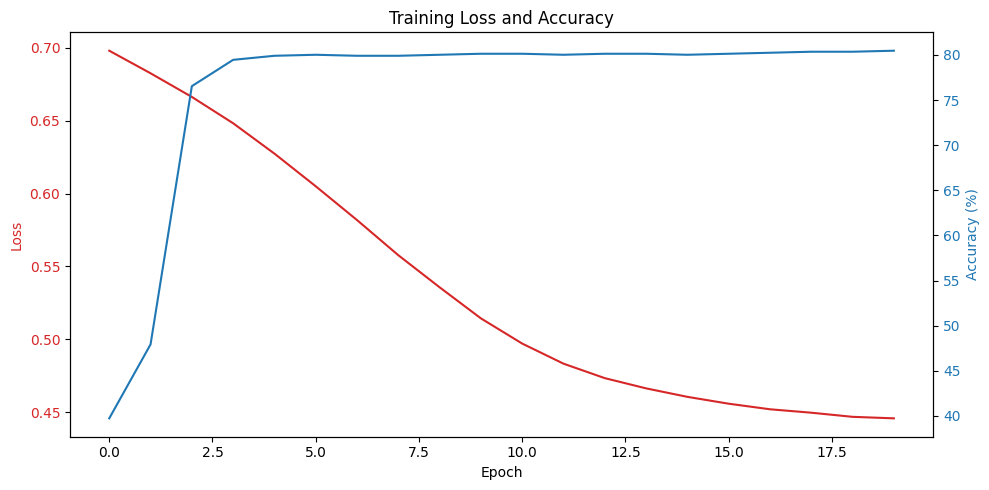

In [38]:
import matplotlib.pyplot as plt

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_losses, label='Training Loss', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx() 

# Plot Accuracy on the secondary y-axis
color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(train_accuracies, label='Training Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Add title and legend
plt.title('Training Loss and Accuracy')
fig.tight_layout()  # Adjust layout for better readability
plt.show()

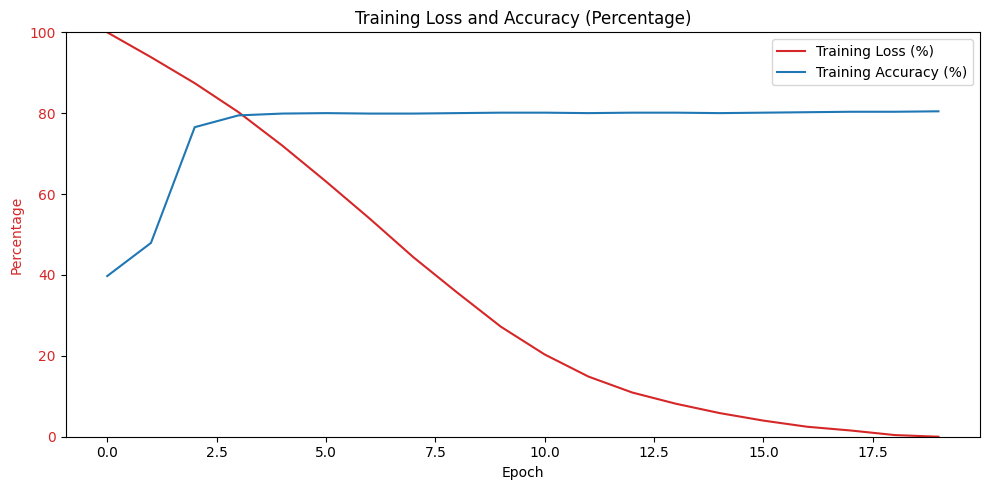

In [39]:

# Normalize Loss to 0-100% scale
min_loss = np.min(train_losses)
max_loss = np.max(train_losses)
normalized_losses = [(loss - min_loss) / (max_loss - min_loss) * 100 for loss in train_losses]

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Loss on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Percentage', color=color)
ax1.plot(normalized_losses, label='Training Loss (%)', color=color)
ax1.plot(train_accuracies, label='Training Accuracy (%)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 100)  # Set y-axis limits to 0-100%

# Add title and legend
plt.title('Training Loss and Accuracy (Percentage)')
fig.tight_layout()
plt.legend()
plt.show()

# Testing Notes:

* ## Test 1 - First output performed okay. Loss in the training seemed high possibly due to complexity of the model. Although accuracy is not a bad start sitting around 80% and gradually reaching that point. However it does plateau.

# SAVE OUTPUT

In [40]:
# Set model to evaluation mode
model.eval()

# Turn off gradient calculation to save memory and computation
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Get model's predictions
    predicted_labels = torch.round(test_outputs).int()  # Convert to integers


# Convert predictions back to a list
predicted_labels = predicted_labels.cpu().numpy().flatten()

# Create the submission DataFrame
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predicted_labels})

# Save the submission to a CSV file
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")


Your submission was successfully saved!


# FINAL NOTE:

* ### Status: *SUBMITTED*
* #### Score: 0.77511
* #### Rank: 9604 / 17458

* #### NOTE: Needs work
